In [2]:
# Probabilistic PCA on a synthetic dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis

In [4]:
# Define a function to generate a high-dimensional features from a low-dimensional features
def gen_linear_features(low_dim_features, W, mu, sigma):
        
    signal = mu + low_dim_features @ W.transpose()
    noise = sigma * np.random.randn(low_dim_features.shape[0], W.shape[0])
    
    return signal + noise

def generate_high_dim_features(low_dim_features, W, mu, sigma):
    
    # Apply a non-linear transformation to the low-dimensional features
    transformed_features = np.tanh(low_dim_features)
    
    signal = mu + transformed_features @ W.transpose()
    noise = sigma * np.random.randn(low_dim_features.shape[0], W.shape[0])
    
    return signal + noise

In [5]:
# Generate some data
np.random.seed(0)
n_samples = 500
n_features = 100
n_latent_features = 2

# ID characteristics
W = np.random.randn(n_features, n_latent_features) * 1.0
mu = np.random.randn(n_features) * .5
sigma = 0.5

# Generate Z as non-independent features
cov = np.array([[1.0, 0.6], [0.6, 1.0]])
low_dim_Z = np.random.multivariate_normal(np.zeros(n_latent_features), cov, n_samples)

# Generate high-dimensional features linear and non-linear
print("Mu shape: ", mu.shape)
print("W shape: ", W.shape)
print("Low dim Z shape: ", low_dim_Z.shape)

X_lin = gen_linear_features(low_dim_Z, W, mu, sigma)
X_nonlin = generate_high_dim_features(low_dim_Z, W, mu, sigma)

print(f'Low-dimensional features shape: {low_dim_Z.shape}'
      f'\nHigh-dimensional features shape: {X_lin.shape}')

Mu shape:  (100,)
W shape:  (100, 2)
Low dim Z shape:  (500, 2)
Low-dimensional features shape: (500, 2)
High-dimensional features shape: (500, 100)


In [6]:
# Fit PCA and KPCA on both linear and non-linear features 
np.random.seed(0)

fa = FactorAnalysis(n_components=n_latent_features)
fa.fit(X_lin)

FactorAnalysis(n_components=2)

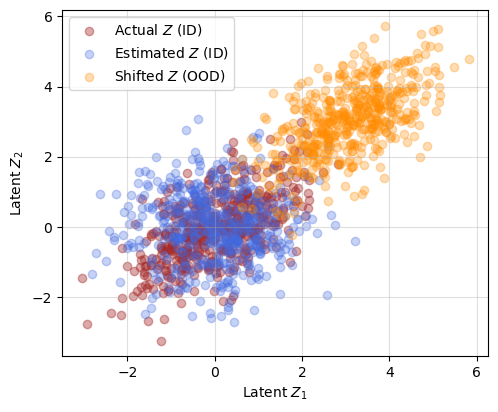

In [7]:
# Now plot in the same plot the true latent features and the estimated latent features
fa_z = fa.transform(X_lin)
z_OOD = np.random.multivariate_normal(np.zeros(n_latent_features) + 3.0, cov, n_samples)

plt.figure(figsize=(5.5, 4.5))
plt.grid(alpha=0.4)
plt.scatter(low_dim_Z[:, 0], low_dim_Z[:, 1], label='Actual $Z$ (ID)', color='brown', alpha=0.4)
plt.scatter(fa_z[:, 0], fa_z[:, 1], label='Estimated $Z$ (ID)', color='royalblue', alpha=0.3)
plt.scatter(z_OOD[:, 0], z_OOD[:, 1], label='Shifted $Z$ (OOD)', color='darkorange', alpha=0.3)
plt.xlabel('Latent $Z_1$')
plt.ylabel('Latent $Z_2$')
plt.legend()
plt.show()


In [8]:
import torch
from utils.cov_shift_tests import multi_gauss_wass_dist, multi_gauss_kl_div, multi_gauss_js_div

K = 10  # Number of folds
th_dict = {'kl_div': [], 'js_div': [], 'wass_dist': []}

for k in range(K):
    
    print(f'Fold {k+1}/{K}')
    
    # randomly split X into training and test sets
    n_train = int(0.8 * n_samples)
    idx = np.random.permutation(n_samples)
    X_train = X_lin[idx[:n_train]]
    X_test = X_lin[idx[n_train:]]

    # Fit the FA on the training set
    fa = FactorAnalysis(n_components=n_latent_features)
    fa.fit(X_train)

    # Transform the training and test sets
    fa_z_train = fa.transform(X_train)
    fa_z_test = fa.transform(X_test)
    
    # Compute mean and covariance of fa_z_train and fa_z_test
    mu_train = np.mean(fa_z_train, axis=0)
    mu_test = np.mean(fa_z_test, axis=0)
    cov_train = np.cov(fa_z_train, rowvar=False)
    cov_test = np.cov(fa_z_test, rowvar=False)
    
    # Compute the KL, JS and Wasserstein distances
    kl_div = multi_gauss_kl_div(torch.tensor(mu_train), torch.tensor(mu_test),
                                 torch.tensor(cov_train), torch.tensor(cov_test))
    js_div = multi_gauss_js_div(torch.tensor(mu_train), torch.tensor(mu_test),
                                torch.tensor(cov_train), torch.tensor(cov_test))
    wass_dist = multi_gauss_wass_dist(torch.tensor(mu_train), torch.tensor(mu_test),
                                      torch.tensor(cov_train), torch.tensor(cov_test))

    th_dict['kl_div'].append(kl_div)
    th_dict['js_div'].append(js_div)
    th_dict['wass_dist'].append(wass_dist)

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [9]:
# Only select the 95% quantile for the threshold for each metric
th = {key: np.quantile(th_dict[key], 0.95) for key in th_dict.keys()}
print(th)

{'kl_div': 0.0637194827693834, 'js_div': 0.014947387147492351, 'wass_dist': 0.08081816893576345}


In [40]:
from utils.utils import compute_metrics
from copy import deepcopy

ref_std = 1.0
num_std = np.linspace(0.0, 1.0, 10)

# Now the game is the following. For say 100 times, for each loop pass we will generate a sample of 100 points with a 50% chance of the whole sample being ID (i.e., a subsample of X_lin) and a 50% chance of being OOD (i.e., z_OOD = z plus n stds). We will then compute the FA features and the corresponding metrics. We will then compare the metrics with the threshold and count the number of times we are above the threshold. We will then plot the number of times we are above the threshold as a function of the number of standard deviations.

n_test = 100
n_loops = 100
n_ID = int(n_test / 2)
n_OOD = n_test - n_ID

OOD_labels = np.zeros(n_test)
OOD_labels[n_ID:] = 1.

# Loop over the number of standard deviations
methods = {'KL Div': [], 'JS Div': [], 'Wass Dist': []}
tpr_dict = {'mean': deepcopy(methods), 'std': deepcopy(methods)}
fpr_dict = {'mean': deepcopy(methods), 'std': deepcopy(methods)}
auroc_dict = {'mean': deepcopy(methods), 'std': deepcopy(methods)}
val_dict = {'mean': deepcopy(methods), 'std': deepcopy(methods)}

for i in num_std:
    
    tpr_dict_i, fpr_dict_i, auroc_dict_i = deepcopy(methods), deepcopy(methods), deepcopy(methods)
    val_dict_i = deepcopy(methods)
    
    for _ in range(20):
    
        # Initialize the counters
        count_dict, collect_dict = deepcopy(methods), deepcopy(methods)
        
        for loop in range(n_loops):
                        
            # Generate the samples
            idx = np.random.permutation(n_test)
            if loop < n_ID:
                # Generate ID samples
                X = X_lin[idx[:n_ID]]
            else:
                # Generate OOD samples
                z_OOD = np.random.multivariate_normal(np.zeros(n_latent_features) + i, cov, n_OOD)
                X = gen_linear_features(z_OOD, W, mu, sigma)
            
            # Fit the FA on the test set
            fa_z = fa.transform(X)
            
            # Compute mean and covariance of  fa_z_test
            mu_test = np.mean(fa_z, axis=0)
            cov_test = np.cov(fa_z, rowvar=False)
            
            # Compute the KL, JS and Wasserstein distances
            kl_div = multi_gauss_kl_div(torch.tensor(mu_train), torch.tensor(mu_test),
                                         torch.tensor(cov_train), torch.tensor(cov_test))
            js_div = multi_gauss_js_div(torch.tensor(mu_train), torch.tensor(mu_test),
                                        torch.tensor(cov_train), torch.tensor(cov_test))
            wass_dist = multi_gauss_wass_dist(torch.tensor(mu_train), torch.tensor(mu_test),
                                              torch.tensor(cov_train), torch.tensor(cov_test))
            
            collect_dict['KL Div'].append(kl_div)
            collect_dict['JS Div'].append(js_div)
            collect_dict['Wass Dist'].append(wass_dist)
        
            # Update the OOD pred counters
            kl_div_, js_div_, wass_dist_ = kl_div > th['kl_div'], js_div > th['js_div'], wass_dist > th['wass_dist']
            count_dict['KL Div'].append(kl_div_)
            count_dict['JS Div'].append(js_div_)
            count_dict['Wass Dist'].append(wass_dist_)
        
        # Save mean and std values for the metrics
        for key in val_dict_i.keys():
            val_dict_i[key].append(np.mean(collect_dict[key]))
        
        # Save metrics
        for key in tpr_dict_i.keys():
            auroc_, tpr_, fpr_ = compute_metrics(OOD_labels, np.array(count_dict[key]))
            tpr_dict_i[key].append(tpr_)
            fpr_dict_i[key].append(fpr_)
            auroc_dict_i[key].append(auroc_)
            
    # Save the mean and std values for the values and metrics over the 100 loops
    for key in val_dict_i.keys():
        val_dict['mean'][key].append(np.mean(val_dict_i[key]))
        val_dict['std'][key].append(np.std(val_dict_i[key]))
        
    for key in tpr_dict_i.keys():
        tpr_dict['mean'][key].append(np.mean(tpr_dict_i[key]))
        tpr_dict['std'][key].append(np.std(tpr_dict_i[key]))
        fpr_dict['mean'][key].append(np.mean(fpr_dict_i[key]))
        fpr_dict['std'][key].append(np.std(fpr_dict_i[key]))
        auroc_dict['mean'][key].append(np.mean(auroc_dict_i[key]))
        auroc_dict['std'][key].append(np.std(auroc_dict_i[key]))
        

In [41]:
print("AUROC: ", auroc_dict)

AUROC:  {'mean': {'KL Div': [0.625683974166519, 0.6618590351966509, 0.7333053998845875, 0.819922450187133, 0.8822961343791216, 0.9372329958726778, 0.9282478633208895, 0.9453319754444106, 0.9329537689012515, 0.9380805350387618], 'JS Div': [0.6372945613501527, 0.6667783720670933, 0.7556435456797803, 0.8383657990729956, 0.8968541054356376, 0.9437869524093729, 0.9340596281760216, 0.947331794866886, 0.9368212081646552, 0.940491941239556], 'Wass Dist': [0.66797116912394, 0.7008816287786106, 0.7825457122470153, 0.8668278712142206, 0.9299880706544899, 0.9536899911936889, 0.9471613413622404, 0.9548028218962774, 0.9535917523658, 0.9446034636623807]}, 'std': {'KL Div': [0.04821071727630763, 0.05290922464224487, 0.05585018717704687, 0.036742776797633915, 0.03403454417713528, 0.018569011185270035, 0.023764807862350055, 0.019780096144557037, 0.013714780864253054, 0.020935931204491512], 'JS Div': [0.05018304748018406, 0.04904127811086448, 0.05237277390968778, 0.029187935418967935, 0.02963516206814011

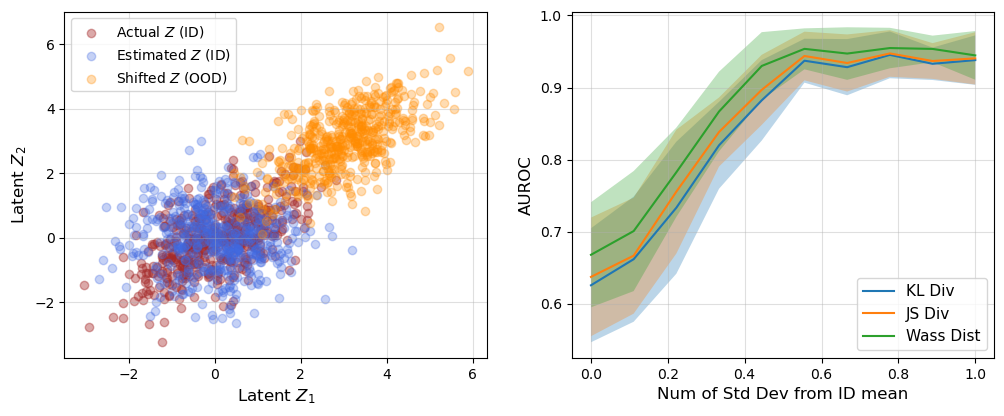

In [42]:
# Now we plot in a 3 subplots plot: i) the illustrative example from above, ii) the mean (with 2*std error bands) of the values of the three distances, but scaled between 0 and 1, and iii) the mean (with 2*std error bands) of the AUROC of the three distances.
np.random.seed(10)

fa_z = fa.transform(X_lin)
z_OOD = np.random.multivariate_normal(np.zeros(n_latent_features) + 3.0, cov, n_samples)

fig = plt.figure(figsize=(12,4.5))
fig.subplots_adjust(wspace=0.2, hspace=0.)

# i) Plot illustrative example
plt.subplot(1, 2, 1)
plt.grid(alpha=0.4)
plt.scatter(low_dim_Z[:, 0], low_dim_Z[:, 1], label='Actual $Z$ (ID)', color='brown', alpha=0.4)
plt.scatter(fa_z[:, 0], fa_z[:, 1], label='Estimated $Z$ (ID)', color='royalblue', alpha=0.3)
plt.scatter(z_OOD[:, 0], z_OOD[:, 1], label='Shifted $Z$ (OOD)', color='darkorange', alpha=0.3)
plt.xlabel('Latent $Z_1$', fontsize=12)
plt.ylabel('Latent $Z_2$', fontsize=12)
plt.legend()

# # ii) Plot mean and std of the three distances, firstly scaling them between 0 and 1
# plt.subplot(1, 3, 2)
# plt.grid(alpha=0.4)
# for key in val_dict['mean'].keys():
#     mean = np.array(val_dict['mean'][key]) + np.random.randn(len(val_dict['mean'][key])) * 0.01
#     std = np.array(val_dict['std'][key])
#     plt.plot(num_std, (mean - np.min(mean)) / (np.max(mean) - np.min(mean)), label=key)
#     plt.fill_between(num_std, (mean - 2*std - np.min(mean)) / (np.max(mean) - np.min(mean)),
#                      (mean + 2*std - np.min(mean)) / (np.max(mean) - np.min(mean)), alpha=0.3)
#     
# plt.xlabel('Num of Std Dev from ID mean', fontsize=12)
# plt.ylabel('Normalized distance', fontsize=12)
# plt.legend()

# iii) Plot mean and std of the AUROC
plt.subplot(1, 2, 2)
plt.grid(alpha=0.4)
for key in auroc_dict['mean'].keys():
    mean = np.array(auroc_dict['mean'][key])
    std = np.array(auroc_dict['std'][key])
    plt.plot(num_std, mean, label=key)
    plt.fill_between(num_std, mean - 1.64*std, mean + 1.64*std, alpha=0.3)
    
plt.xlabel('Num of Std Dev from ID mean', fontsize=12)
plt.ylabel('AUROC', fontsize=12)
plt.legend(loc='lower right', fontsize=11)

# Save the plot
plt.savefig('images/FA_synthetic_data.pdf', dpi=300)